Step 1: Import Necessary Libraries

In [1]:
!pip install tensorflow==2.18.0


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE

Step 2: Load the Dataset

In [3]:
# Load the dataset
df = pd.read_csv('loan_data.csv')  # Replace 'loan_data.csv' with your actual file name

# Display the first few rows of the dataset
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Step 3: Check for Null Values

In [5]:
# Check for null values
print("Missing Values:\n", df.isnull().sum())

df.dropna(inplace=True)  # Drop missing values
# df = df.fillna(df.mean())  # Example: Fill numerical columns with mean

Missing Values:
 SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64


Step 4: Print the Percentage of Default to Payer

In [6]:
# Assuming the target column is named 'TARGET'
default_percentage = df['TARGET'].value_counts(normalize=True) * 100
print(f"Percentage of Default: {default_percentage[1]:.2f}%")

Percentage of Default: 6.11%


Step 5: Balance the Dataset if Imbalanced


TARGET Distribution:
 TARGET
0    93.885143
1     6.114857
Name: proportion, dtype: float64


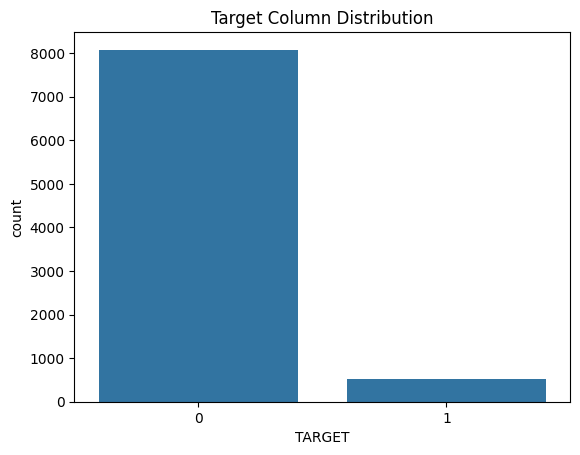

Dataset is imbalanced. Balancing using SMOTE...


In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Check target column distribution
print("\nTARGET Distribution:\n", df['TARGET'].value_counts(normalize=True) * 100)
sns.countplot(x='TARGET', data=df)
plt.title("Target Column Distribution")
plt.show()

# Balance dataset using SMOTE
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_encoding', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # Leave numeric columns unchanged
)

# Transform the data
X_encoded = preprocessor.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y)


 # Check if the dataset is imbalanced
if df['TARGET'].value_counts()[1] / df['TARGET'].value_counts()[0] < 0.5:
    print("Dataset is imbalanced. Balancing using SMOTE...")
    smote = SMOTE(random_state=42)
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    X_res, y_res = smote.fit_resample(X, y)
    df = pd.concat([X_res, y_res], axis=1)   

Step 6: Plot the Balanced or Imbalanced Data

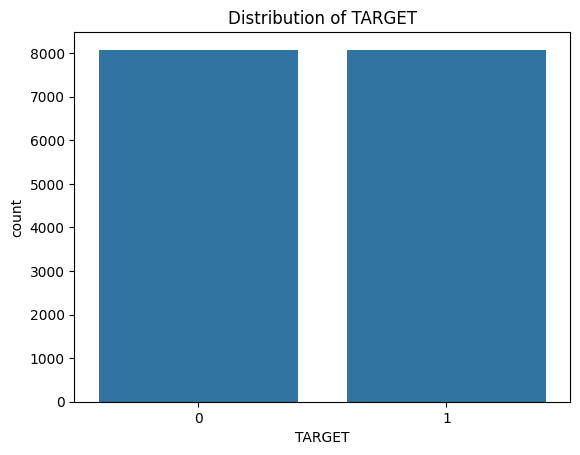

In [12]:
# Plot the distribution of the target variable
sns.countplot(x='TARGET', data=df)
plt.title('Distribution of TARGET')
plt.show()

Step 7: Encode the Columns Required for the Model

In [13]:
# Encode categorical variables if any
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

Step 8: Split the Data into Training and Testing Sets

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 9: Build the Deep Learning Model

In [15]:
# Build the deep learning model
#A Sequential model in deep learning is a linear stack of layers where each layer has exactly one input tensor and one output tensor. 
# It is one of the simplest ways to build a neural network in frameworks like TensorFlow/Keras. The layers are added sequentially, one after another, and the data flows through the layers in the same order.
model = Sequential()
# Adding a fully connected(dense) layers with 128 neurons and 'relu' activation function.
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
# Adding dropout layer with a dropout rate of 0.5 to prevent overfitting.
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# Adding the output layer with 1 neuron and 'sigmoid' activation function for binary classification.
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50


/Users/qunxu/Documents/guild/AI/guild_projects/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - accuracy: 0.6904 - loss: 0.6171 - val_accuracy: 0.9447 - val_loss: 0.1739
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.9307 - loss: 0.2100 - val_accuracy: 0.9528 - val_loss: 0.1462
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.9525 - loss: 0.1555 - val_accuracy: 0.9571 - val_loss: 0.1375
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.9618 - loss: 0.1315 - val_accuracy: 0.9590 - val_loss: 0.1342
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.9619 - loss: 0.1254 - val_accuracy: 0.9590 - val_loss: 0.1317
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.9655 - loss: 0.1104 - val_accuracy: 0.9598 - val_loss: 0.1288
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.9667 - loss: 0.1093 - val_accuracy: 0.9586 - val_loss: 0.1314
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.9669 - loss: 0.1075 - val_accurac

Step 10: Calculate Sensitivityand ROC-AUC

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
Sensitivity (True Positive Rate): 0.93
ROC-AUC: 0.98


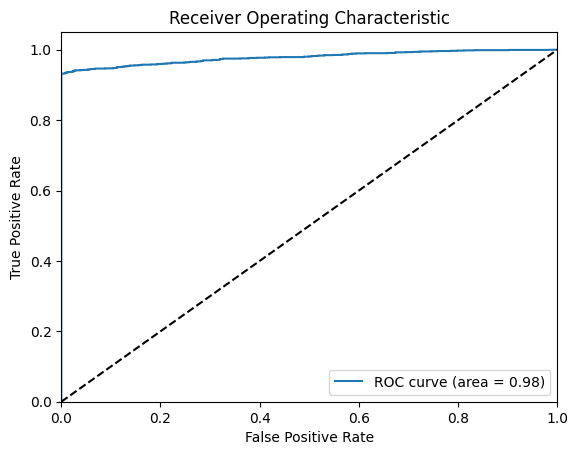

In [16]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate Sensitivity (True Positive Rate)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
print(f"Sensitivity (True Positive Rate): {sensitivity:.2f}")

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Step 11: Evaluate the Model

In [17]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.3323
Test Accuracy: 0.9622
